# Problem Definition

The datathon results should contain predictions for each ATM for each day and should be provided in csv format consisting of three columns:

* CASHPOINTID - unique identifier of ATM for which the prediction is made;
* OPERATIONDATE - date (must be in [2020-01-01 - 2020-01-31] period) for which the prediction is made;
* AMT_SCALED - predicted total daily withdrawal amount (scaled)

Participants will be asked for the repository in which they built the forecasting model.

After submitting the results, participants are expected to explain their approach, extracted insights and model.



Work done will be evaluated according to the following criteria:

* OOS (Out of Sample) error metrics;
* Ability to communicate the results;
* Code quality and implementability.


# Imports

In [1]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np

In [2]:
os.chdir('../')

# Read Data

* CASHPOINTID - unique identifier of ATM for which the prediction is made;
* OPERATIONDATE - date (must be in [2020-01-01 - 2020-01-31] period) for which the prediction is made;
* AMT_SCALED - predicted total daily withdrawal amount (scaled)

In [3]:
df = pd.read_csv('data/train_aggregated_by_day.csv')
df.date = pd.to_datetime(df.date)
df.set_index('date', inplace=True)

In [4]:
df.head()

,id,amt
date,,
2017-01-01,0,0.027997
2017-01-02,0,0.040519
2017-01-03,0,0.136281
2017-01-04,0,0.000074
2017-01-05,0,0.075411


# Data Preprocessing

### generate sliding windows

In [270]:
def get_window(dataframe, size=10, by='id', target='amt'):
    columns = []
    for column in dataframe.columns:
        for idx in range(size):
            columns.append(f'{column}(t-{size-idx})')
        
    records = []
    targets = []
    indices = []
    for grp_id, group in dataframe.groupby('id'):
        for target_idx in range(0, len(group) - size - 1):
            record = []
            for column_idx, column in enumerate(group.columns):
                for idx in range(size):
                    record.append(group.iloc[target_idx+idx, column_idx])
            
            indices.append(group.index[target_idx+size])
            records.append(record)
            targets.append(group.iloc[target_idx+size, -1])
        
    return pd.DataFrame(records, index=indices, columns=columns), pd.DataFrame(targets)

In [92]:
_X, _Y = get_window(df.head(200))

In [94]:
_X.head()

,id(t-10),id(t-9),id(t-8),id(t-7),id(t-6),id(t-5),id(t-4),id(t-3),id(t-2),id(t-1),amt(t-10),amt(t-9),amt(t-8),amt(t-7),amt(t-6),amt(t-5),amt(t-4),amt(t-3),amt(t-2),amt(t-1)
2017-01-11,0,0,0,0,0,0,0,0,0,0,0.027997,0.040519,0.136281,0.000074,0.075411,0.107680,0.042070,0.040568,0.102029,0.137586
2017-01-12,0,0,0,0,0,0,0,0,0,0,0.040519,0.136281,0.000074,0.075411,0.107680,0.042070,0.040568,0.102029,0.137586,0.000000
2017-01-13,0,0,0,0,0,0,0,0,0,0,0.136281,0.000074,0.075411,0.107680,0.042070,0.040568,0.102029,0.137586,0.000000,0.092179
2017-01-14,0,0,0,0,0,0,0,0,0,0,0.000074,0.075411,0.107680,0.042070,0.040568,0.102029,0.137586,0.000000,0.092179,0.108690
2017-01-15,0,0,0,0,0,0,0,0,0,0,0.075411,0.107680,0.042070,0.040568,0.102029,0.137586,0.000000,0.092179,0.108690,0.070030


In [95]:
_Y.head()

,0
2017-01-11,0.000000
2017-01-12,0.092179
2017-01-13,0.108690
2017-01-14,0.070030
2017-01-15,0.063899


In [96]:
X, Y = get_window(dataframe=df, size=7, by='id', target='amt')

In [108]:
dataset = pd.concat([X, Y], axis=1)

In [110]:
# dataset.to_csv('data/preprocessed_dataset_for_lstm_with_sliding_window_of_7.csv')

In [111]:
# dataset = pd.read_csv('data/preprocessed_dataset_for_lstm_with_sliding_window_of_7.csv', index_col=0)
# dataset.index = pd.to_datetime(dataset.index)

### train/test split

In [112]:
df.index.min(), df.index.max(), (df.index.max() - df.index.min())/2

(Timestamp('2017-01-01 00:00:00'),
 Timestamp('2019-12-31 00:00:00'),
 Timedelta('547 days 00:00:00'))

it's good to include last year's new year month in test split

In [113]:
dataset[dataset.index < pd.Timestamp('2018-12-31')].shape

(757832, 15)

In [114]:
train_df, test_df = dataset[dataset.index < pd.Timestamp('2018-12-31')], dataset[dataset.index >= pd.Timestamp('2018-12-31')]

# Train LSTM Model

In [144]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import keras

In [139]:
def save_model(model, path):
    model.save(path)

In [145]:
def load_model(path):
    return keras.models.load_model(path)

### get features and targets

In [326]:
train_X, train_y = train_df.iloc[:, :-1].values, train_df.iloc[:, -1].values
test_X, test_y = test_df.iloc[:, :-1].values, test_df.iloc[:, -1].values

### reshape input to be 3D [samples, timesteps, features]

In [327]:
train_X = train_X.reshape(train_X.shape[0], 2, train_X.shape[1]//2).transpose(0, 2, 1)
test_X = test_X.reshape(test_X.shape[0], 2, test_X.shape[1]//2).transpose(0, 2, 1)

print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(757832, 7, 2) (757832,) (323457, 7, 2) (323457,)


In [328]:
model = Sequential()
model.add(LSTM(20, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

In [329]:
history = model.fit(
    train_X,
    train_y, 
    epochs=50, 
    batch_size=72, 
    validation_data=(test_X, test_y),
    verbose=5, 
    shuffle=False
)

Train on 757832 samples, validate on 323457 samples
Epoch 1/50
Epoch 2/50
Epoch 3/50
Epoch 4/50
Epoch 5/50
Epoch 6/50
Epoch 7/50
Epoch 8/50
Epoch 9/50
Epoch 10/50
Epoch 11/50
Epoch 12/50
Epoch 13/50
Epoch 14/50
Epoch 15/50
Epoch 16/50
Epoch 17/50
Epoch 18/50
Epoch 19/50
Epoch 20/50
Epoch 21/50
Epoch 22/50
Epoch 23/50
Epoch 24/50
Epoch 25/50
Epoch 26/50
Epoch 27/50
Epoch 28/50
Epoch 29/50
Epoch 30/50
Epoch 31/50
Epoch 32/50
Epoch 33/50
Epoch 34/50
Epoch 35/50
Epoch 36/50
Epoch 37/50
Epoch 38/50
Epoch 39/50
Epoch 40/50
Epoch 41/50
Epoch 42/50
Epoch 43/50
Epoch 44/50
Epoch 45/50
Epoch 46/50
Epoch 47/50
Epoch 48/50
Epoch 49/50
Epoch 50/50


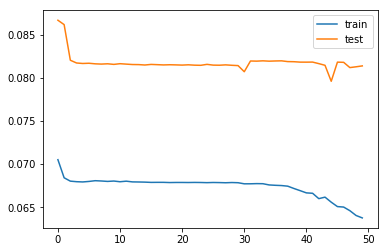

In [330]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [331]:
save_model(model, 'data/lstm_model_v1')

# Predict on Test Set

In [332]:
def generate_test_dataset(ids):
    records = []
    for _id in ids:
        for _date in pd.date_range('2020-01-01', '2020-01-31'):
            records.append([_date, _id, None])
    
    return pd.DataFrame(records, columns=['date', 'id', 'amt']).set_index('date')

In [333]:
generate_test_dataset(df.id.unique()).head()

,id,amt
date,,
2020-01-01,0,None
2020-01-02,0,None
2020-01-03,0,None
2020-01-04,0,None
2020-01-05,0,None


In [334]:
test_dataset = generate_test_dataset(df.id.unique())

In [335]:
# test_dataset.to_csv('data/test_empty.csv')

We have to generate predictions for given dates

In [336]:
test_dataset_dates = test_dataset.index.unique()

In [338]:
test_dataset_dates

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10', '2020-01-11', '2020-01-12',
               '2020-01-13', '2020-01-14', '2020-01-15', '2020-01-16',
               '2020-01-17', '2020-01-18', '2020-01-19', '2020-01-20',
               '2020-01-21', '2020-01-22', '2020-01-23', '2020-01-24',
               '2020-01-25', '2020-01-26', '2020-01-27', '2020-01-28',
               '2020-01-29', '2020-01-30', '2020-01-31'],
              dtype='datetime64[ns]', name='date', freq=None)

In [339]:
def predict_on_sample(model, sample):
    if sample.shape == (1,1,14):
        return model.predict(sample)[0][0]
    else:
        return model.predict(sample.reshape((1,1,14)).reshape((1,2,7)).transpose(0,2,1))[0][0]

In [340]:
predict_on_sample(model, train_X[1])

0.09134039

window size = 7, so we need to use last 7 records from test dataset split to use them in predictions

In [341]:
def generate_test_data_with_padding(ids):
    records = []
    for _id in ids:
        for _date in pd.date_range('2019-12-25', '2020-01-31'):
            if _date > pd.Timestamp('2019-12-31'):
                records.append([_date, _id, None])
            else:
                if _id in df.loc[_date].id.values:
                    value = df[df.id==_id].loc[_date, "amt"]
                else:
                    value = None
                
                records.append([_date, _id, value])
    
    return pd.DataFrame(records, columns=['date', 'id', 'amt']).set_index('date')

In [342]:
test_dataset_padded = generate_test_data_with_padding(df.id.unique())

In [343]:
test_dataset_padded.head()

,id,amt
date,,
2019-12-25,0,0.143766
2019-12-26,0,0.168366
2019-12-27,0,0.265199
2019-12-28,0,0.182389
2019-12-29,0,0.157211


make predictions

In [353]:
predictions = {}
for _id in df.id.unique():
    print(f'ID:{_id}')
    _df = test_dataset_padded[test_dataset_padded.id == _id]
    for st_idx in range(len(_df)-7):
        prev_amts = _df.iloc[st_idx:st_idx+7, -1].fillna(0.0).tolist()
        sample_input = [_id]*7 + prev_amts
        
        prediction = predict_on_sample(model, np.array(sample_input))
        _df.iloc[st_idx+7, -1] = prediction
        
        test_dataset[test_dataset.id==_id].loc[_df.index[st_idx+7], "amt"] = prediction
        predictions[(str(_df.index[st_idx+7]), _id)] = prediction

ID:0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


ID:1
ID:2
ID:3
ID:4
ID:5
ID:6
ID:7
ID:8
ID:9
ID:10
ID:11
ID:12
ID:13
ID:14
ID:15
ID:16
ID:17
ID:18
ID:19
ID:20
ID:21
ID:22
ID:23
ID:24
ID:25
ID:26
ID:27
ID:28
ID:29
ID:30
ID:31
ID:32
ID:33
ID:34
ID:35
ID:36
ID:37
ID:38
ID:39
ID:40
ID:41
ID:42
ID:43
ID:44
ID:45
ID:46
ID:47
ID:48
ID:49
ID:50
ID:51
ID:52
ID:53
ID:54
ID:55
ID:56
ID:57
ID:58
ID:59
ID:60
ID:61
ID:62
ID:63
ID:64
ID:65
ID:66
ID:67
ID:68
ID:69
ID:70
ID:71
ID:72
ID:73
ID:74
ID:75
ID:76
ID:77
ID:78
ID:79
ID:80
ID:81
ID:82
ID:83
ID:84
ID:85
ID:86
ID:87
ID:88
ID:89
ID:90
ID:91
ID:92
ID:93
ID:94
ID:95
ID:96
ID:97
ID:98
ID:99
ID:100
ID:101
ID:102
ID:103
ID:104
ID:105
ID:106
ID:107
ID:108
ID:109
ID:110
ID:111
ID:112
ID:113
ID:114
ID:115
ID:116
ID:117
ID:118
ID:119
ID:120
ID:121
ID:122
ID:123
ID:124
ID:125
ID:126
ID:127
ID:128
ID:129
ID:130
ID:131
ID:132
ID:133
ID:134
ID:135
ID:136
ID:137
ID:138
ID:139
ID:140
ID:141
ID:142
ID:143
ID:144
ID:145
ID:146
ID:147
ID:148
ID:149
ID:150
ID:151
ID:152
ID:153
ID:154
ID:155
ID:156
ID:157
ID:158
ID

ID:1198
ID:1199
ID:1200
ID:1201
ID:1202
ID:1203
ID:1204
ID:1205
ID:1206
ID:1207
ID:1208
ID:1209
ID:1210
ID:1211
ID:1212
ID:1213
ID:1214
ID:1215
ID:1216
ID:1217
ID:1218
ID:1219
ID:1220
ID:1221
ID:1222
ID:1223
ID:1224
ID:1225
ID:1226
ID:1227
ID:1228
ID:1229
ID:1230
ID:1231
ID:1232
ID:1233
ID:1234
ID:1235
ID:1236
ID:1237
ID:1238
ID:1239
ID:1240
ID:1241
ID:1242
ID:1243
ID:1244
ID:1245
ID:1246
ID:1247
ID:1248
ID:1249
ID:1250
ID:1251
ID:1252
ID:1253
ID:1254
ID:1255
ID:1256
ID:1257
ID:1258
ID:1259
ID:1260
ID:1261
ID:1262
ID:1263
ID:1264
ID:1265
ID:1266
ID:1267
ID:1268
ID:1269
ID:1270
ID:1271
ID:1272
ID:1273
ID:1274
ID:1275
ID:1276
ID:1277
ID:1278
ID:1279
ID:1280
ID:1281
ID:1282
ID:1283
ID:1284
ID:1285
ID:1286
ID:1287
ID:1288
ID:1289
ID:1290
ID:1291
ID:1292
ID:1293
ID:1294
ID:1295
ID:1296
ID:1297
ID:1298
ID:1299
ID:1300
ID:1301
ID:1302
ID:1303
ID:1304
ID:1305
ID:1306
ID:1307
ID:1308
ID:1309
ID:1310
ID:1311
ID:1312
ID:1313
ID:1314
ID:1315
ID:1316
ID:1317
ID:1318
ID:1319
ID:1320
ID:1321
ID:1322


In [357]:
len(predictions) == df.id.unique().shape[0]*31

True

In [401]:
_predictions_df = pd.concat(
    [
        pd.DataFrame(list(predictions.keys()), columns=['OPERATIONDATE', 'CASHPOINTID']), 
        pd.DataFrame(predictions.values(), columns=['AMT_SCALED'])
    ],
    axis=1
)

In [402]:
_predictions_df.OPERATIONDATE = pd.to_datetime(_predictions_df.OPERATIONDATE)

In [404]:
_predictions_df.head()

,OPERATIONDATE,CASHPOINTID,AMT_SCALED
0,2020-01-01,0,0.160129
1,2020-01-02,0,0.158472
2,2020-01-03,0,0.159404
3,2020-01-04,0,0.158043
4,2020-01-05,0,0.157556


In [405]:
_predictions_df.to_csv('data/submisson_simple_lstm.csv', index=False)